#1.0 Cannabis E-Commerce User Behavior & Hybrid Recommendation System

This project analyzes user interactions with products in an e-commerce setting to understand engagement patterns and build a hybrid recommendation system. It combines user-product interaction data with product text information to generate personalized top-N product recommendations. The approach leverages graph embeddings (Node2Vec) for user-product relationships and TF-IDF embeddings for product content, producing a hybrid scoring system that balances user behavior and product similarity.

## Dataset:

The dataset consists of two main components. The first contains information about the products available on the website, including attributes such as product name, vendor, product ID, and price. The second captures user behavior and interactions with these products, detailing each user’s ID, the products they viewed, the type of interaction (e.g., click, save, add to cart, purchase), the quantity purchased, and any ratings provided.

## Goals:

- Explore user-product interactions

- Engineer features capturing engagement

- Build a hybrid recommendation system using text + graph embeddings

- Generate top-5 recommendations for users

#2.0 Import Libaries

In [1]:
!pip install -q node2vec

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from node2vec import Node2Vec
from sklearn.preprocessing import normalize

# 3.0 Load Data

In [3]:
products_df = pd.read_csv('cannabis-prod-data.csv')
user_behavior_df = pd.read_csv('cannabis-user-data.csv')

# 4.0 Exploratory Data Analysis (EDA)

## Data cleaning and exploration.

Here we'll check for missing or inconsistent values in both datasets, validate that product IDs in user behavior match those in the product catalog, explorre distributions such as product availability, categories, prices, user event types, rating distributions, purchase quantities, etc.


## 4a. Quick Overview and Data Inspection

In [4]:
print("\n--- Products Info ---")
print(products_df.info())
print(products_df.head())

print("\n--- User Behavior Info ---")
print(user_behavior_df.info())
print(user_behavior_df.head())


--- Products Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    100 non-null    object 
 1   name          100 non-null    object 
 2   category      100 non-null    object 
 3   strain_type   100 non-null    object 
 4   strain        100 non-null    object 
 5   vendor        100 non-null    object 
 6   THC_pct       100 non-null    float64
 7   CBD_pct       94 non-null     float64
 8   potency_mg    78 non-null     float64
 9   price_usd     100 non-null    float64
 10  availability  100 non-null    int64  
 11  description   89 non-null     object 
 12  tags          100 non-null    object 
 13  date_added    100 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 11.1+ KB
None
  product_id                     name     category strain_type       strain  \
0       p001             OG Kush 3.5g 

---
**Products Catalog Dataset Overview**

---



The dataset contains 100 cannabis products with details such as product ID, name, category (Flower, Concentrate, Edible, etc.), strain type (Sativa, Indica, Hybrid), strain name, vendor, THC/CBD percentages, potency (in mg where applicable), price (USD), availability count, product description, associated effect/experience tags, and date added. THC content is available for all products, CBD content for most (94%), and potency for a subset (78%). Categories span various consumption formats, and products feature diverse strains like OG Kush, Sour Diesel, and Blue Dream, offered by multiple vendors. Availability values indicate current stock, and textual fields capture marketing descriptions and tags highlighting strain effects such as energetic, creative, and euphoric.



---


**User Behavior Dataset Overview**

---



The dataset contains 29.010 user interactions with products, including user_id, product_id, event type (e.g., click, view, purchase), timestamp, optional product ratings (present for 2,604 events), and purchase quantities. Events are time-stamped at the second level, enabling temporal behavior analysis. The data supports tracking engagement patterns, purchase activity, and user preferences across the product catalog.

In [5]:
# check missing values

print("\nMissing values in products:\n", products_df.isna().sum())
print("\nMissing values in user_behavior:\n", user_behavior_df.isna().sum())


Missing values in products:
 product_id       0
name             0
category         0
strain_type      0
strain           0
vendor           0
THC_pct          0
CBD_pct          6
potency_mg      22
price_usd        0
availability     0
description     11
tags             0
date_added       0
dtype: int64

Missing values in user_behavior:
 user_id           0
product_id        0
event_type        0
timestamp         0
rating        26406
quantity      23163
dtype: int64


---
**Missing Values**

---

The products dataframe has 6 rows of missing values in the `CBD_pct` column, 22 rows in the `potency_mg` column, and 11 rows in the `description` column.

The user's behavior dataframe has 26,406 rows without a rating, and 23,163 rows without a quantity observation.


---


Next, we'll check those columns with any missing values for `CBD_pct`, `potency_mg`, and `description` in the `products_df` dataframe.


In [6]:
# check those columns with any missing values CBD_pct, potency_mg, description

products_df[products_df[['CBD_pct', 'potency_mg', 'description']].isna().any(axis = 1)]

,product_id,name,category,strain_type,strain,vendor,THC_pct,CBD_pct,potency_mg,price_usd,availability,description,tags,date_added
0,p001,OG Kush 3.5g,Flower,Sativa,OG Kush,Herbal Haven,28.5,0.8,NaN,54.36,833,"OG Kush Sativa flower with energetic, euphoric...","['energetic', 'euphoric', 'uplifting']",2025-07-29
4,p005,Sour Diesel - 7g,Flower,Sativa,Sour Diesel,Happy Trails,22.9,0.5,NaN,94.93,324,"Sour Diesel Sativa flower with cerebral, eupho...","['cerebral', 'euphoric', 'focused', 'creative']",2025-03-20
5,p006,CA Gold Rush 1/8 oz,Flower,Indica,CA Gold Rush,Zen Garden,21.0,0.9,NaN,38.01,649,"CA Gold Rush Indica flower with body high, rel...","['body high', 'relaxing']",2025-04-22
9,p010,Wedding Cake - 7g,Flower,Indica,Wedding Cake,Happy Trails,17.1,3.7,NaN,99.45,520,"Wedding Cake Indica flower with calming, sleep...","['calming', 'sleepy', 'relaxing', 'body high',...",2025-06-12
10,p011,Lemon Cherry 7g,Flower,Sativa,Lemon Cherry,Pure Bloom,31.0,1.1,NaN,92.80,177,"Lemon Cherry Sativa flower with creative, focu...","['creative', 'focused', 'energetic']",2025-06-06
11,p012,OG Kush 7g,Flower,Sativa,OG Kush,Bud Masters,18.3,0.8,NaN,91.17,848,"OG Kush Sativa flower with uplifting, focused,...","['uplifting', 'focused', 'creative', 'energeti...",2025-07-05
12,p013,Girl Scout Cookies 1000mg,Concentrate,Indica,Girl Scout Cookies,Sunset Wellness,81.0,0.1,1000.0,50.03,170,NaN,"['relaxing', 'sedative', 'body high']",2025-07-15
14,p015,OG Kush 7g,Flower,Hybrid,OG Kush,Herbal Haven,23.1,0.7,NaN,91.38,656,"OG Kush Hybrid flower with energetic, upliftin...","['energetic', 'uplifting', 'sleepy']",2025-08-12
15,p016,Lemon Cherry 3.5g,Flower,Sativa,Lemon Cherry,CannaWorld,20.3,0.3,NaN,57.38,973,"Lemon Cherry Sativa flower with cerebral, crea...","['cerebral', 'creative', 'energetic']",2025-04-21
18,p019,ca gold rush 20 pieces,Edible,Hybrid,CA Gold Rush,Herbal Haven,10.7,NaN,100.0,23.61,0,"CA Gold Rush Hybrid edible with energetic, upl...","['energetic', 'uplifting', 'creative', 'sleepy...",2025-04-03


Check for duplicate rows

In [7]:
# check if there are any duplicate rows

print('There are duplicate rows in product catalog? ', products_df.duplicated().any())

print('\nThere are duplicate rows in user data? ', user_behavior_df.duplicated().any())

There are duplicate rows in product catalog?  False

There are duplicate rows in user data?  False


Merge Datasets

In [8]:
# merge datasets on product_id keeping everything on user data

merged_df = pd.merge(user_behavior_df, products_df, on = 'product_id', how = 'left')

In [9]:
print("\n--- Merged Dataset Info ---")
print(merged_df.info())
print(merged_df.head())


--- Merged Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29010 entries, 0 to 29009
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       29010 non-null  object 
 1   product_id    29010 non-null  object 
 2   event_type    29010 non-null  object 
 3   timestamp     29010 non-null  object 
 4   rating        2604 non-null   float64
 5   quantity      5847 non-null   float64
 6   name          29010 non-null  object 
 7   category      29010 non-null  object 
 8   strain_type   29010 non-null  object 
 9   strain        29010 non-null  object 
 10  vendor        29010 non-null  object 
 11  THC_pct       29010 non-null  float64
 12  CBD_pct       27385 non-null  float64
 13  potency_mg    22584 non-null  float64
 14  price_usd     29010 non-null  float64
 15  availability  29010 non-null  int64  
 16  description   25740 non-null  object 
 17  tags          29010 non-null  object 
 1

## 4b. Basic Stats:

Unique elements:

In [10]:
print(f"\nUnique users: {merged_df['user_id'].nunique()}")
print(f"Unique products: {merged_df['product_id'].nunique()}")
print(f"Unique categories: {merged_df['category'].nunique()}")
print(f"Unique event types: {merged_df['event_type'].nunique()}")


Unique users: 1000
Unique products: 100
Unique categories: 4
Unique event types: 4


What categories are there?

In [11]:
unique_cat = merged_df['category'].unique()
print("Unique categories: ", unique_cat)

Unique categories:  ['Edible' 'Concentrate' 'Vape Cartridge' 'Flower']


What event types are there?

In [12]:
unique_event = merged_df['event_type'].unique()
print("Unique event types: ", unique_event)

Unique event types:  ['view' 'click' 'cart' 'buy']


Count of each event type:

In [13]:
event_counts = merged_df['event_type'].value_counts()
print("\nEvent type counts:\n", event_counts)


Event type counts:
 event_type
view     12688
click     9825
cart      3893
buy       2604
Name: count, dtype: int64


Min / Max Purchase Quantity

In [14]:
min_qty_purchase = merged_df[merged_df['event_type'] == 'buy']['quantity'].min()
max_qty_purchase = merged_df[merged_df['event_type'] == 'buy']['quantity'].max()

print(f"Minimum purchase quantity: {min_qty_purchase}")
print(f"\nMaximum purchase quantity: {max_qty_purchase}")

Minimum purchase quantity: 1.0

Maximum purchase quantity: 10.0


Avg overall purchase quantity and rating

In [15]:
avg_qty_purchase = merged_df[merged_df['event_type'] == 'buy']['quantity'].mean()
print(f"Average purchase quantity: {round(avg_qty_purchase, 2)}"),
print(f"\nAverage rating: {round(merged_df['rating'].mean(), 2)}")

Average purchase quantity: 5.47

Average rating: 3.62


Min / Max Purchase Price and Overall Price

In [16]:
min_price_purchase = merged_df[merged_df['event_type'] == 'buy']['price_usd'].min()
max_price_purchase = merged_df[merged_df['event_type'] == 'buy']['price_usd'].max()
min_price = merged_df['price_usd'].min()
max_price = merged_df['price_usd'].max()

print(f"Minimum purchase price: {round(min_price_purchase, 2)}")
print(f"Maximum purchase price: {round(max_price_purchase, 2)}")
print(f"Minimum price: {round(min_price, 2)}")
print(f"Maximum price: {round(max_price, 2)}")

Minimum purchase price: 22.84
Maximum purchase price: 109.29
Minimum price: 22.64
Maximum price: 109.29


Min / Max Price Product

In [17]:
# get products with the min / max price
min_price_products = merged_df[merged_df['price_usd'] == min_price][['product_id', 'name', 'price_usd', 'category', 'vendor']].drop_duplicates()
max_price_products = merged_df[merged_df['price_usd'] == max_price][['product_id', 'name', 'price_usd', 'category', 'vendor']].drop_duplicates()

min_price_purchase_products = merged_df[merged_df['price_usd'] == min_price_purchase][['product_id', 'name', 'price_usd', 'category', 'vendor']].drop_duplicates()
max_price_purchase_products = merged_df[merged_df['price_usd'] == max_price_purchase][['product_id', 'name', 'price_usd', 'category', 'vendor']].drop_duplicates()

print("Products Purchased with Minimum Price:")
print(min_price_purchase_products)

print("\n\nProducts Purchased with Maximum Price:")
print(max_price_purchase_products)

print("\n\nProducts with Minimum Price:")
print(min_price_products)

print("\n\nProducts with Maximum Price:")
print(max_price_products)

Products Purchased with Minimum Price:
   product_id              name  price_usd category           vendor
58       p055  Sour Diesel 100g      22.84   Edible  Sunset Wellness


Products Purchased with Maximum Price:
    product_id             name  price_usd category        vendor
357       p070  CA Gold Rush 7g     109.29   Flower  Herbal Haven


Products with Minimum Price:
  product_id             name  price_usd category           vendor
9       p061  Jack Herer 100g      22.64   Edible  Sunset Wellness


Products with Maximum Price:
    product_id             name  price_usd category        vendor
357       p070  CA Gold Rush 7g     109.29   Flower  Herbal Haven


Avg Overall Purchase Price and Avg Overall Price

In [18]:
avg_price_purchase = merged_df[merged_df['event_type'] == 'buy']['price_usd'].mean()
avg_price = merged_df['price_usd'].mean()

print(f"Average purchase price: {round(avg_price_purchase, 2)}")
print(f"\nAverage price: {round(avg_price, 2)}")

Average purchase price: 48.38

Average price: 47.12


## 4c. Distribution Plots

### Ratings Distribution

Overall Ratings Distribution

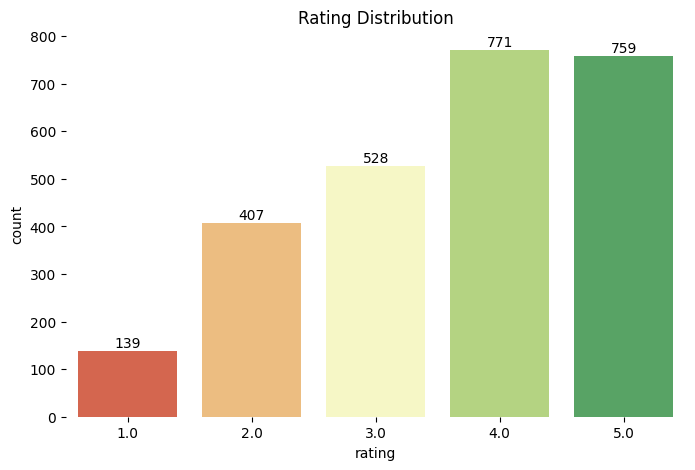

In [19]:
rating_colors = sns.color_palette("RdYlGn", 5)

plt.figure(figsize=(8,5))
ax = sns.countplot(x = 'rating', hue = 'rating', data = merged_df, legend = False,
              order = sorted(merged_df['rating'].dropna().unique()),
              palette = rating_colors)
plt.title('Rating Distribution')


for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x-pos: bar start at x-axis then get wideth divide by two to get center of bar
            height + 1,                     # y-pos: just above bar
            int(height),                    # label as integer
            ha = 'center',                   # horizontal alignment
            va = 'bottom'                    # vertical alignment
        )

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

Ratings Distribution by Category

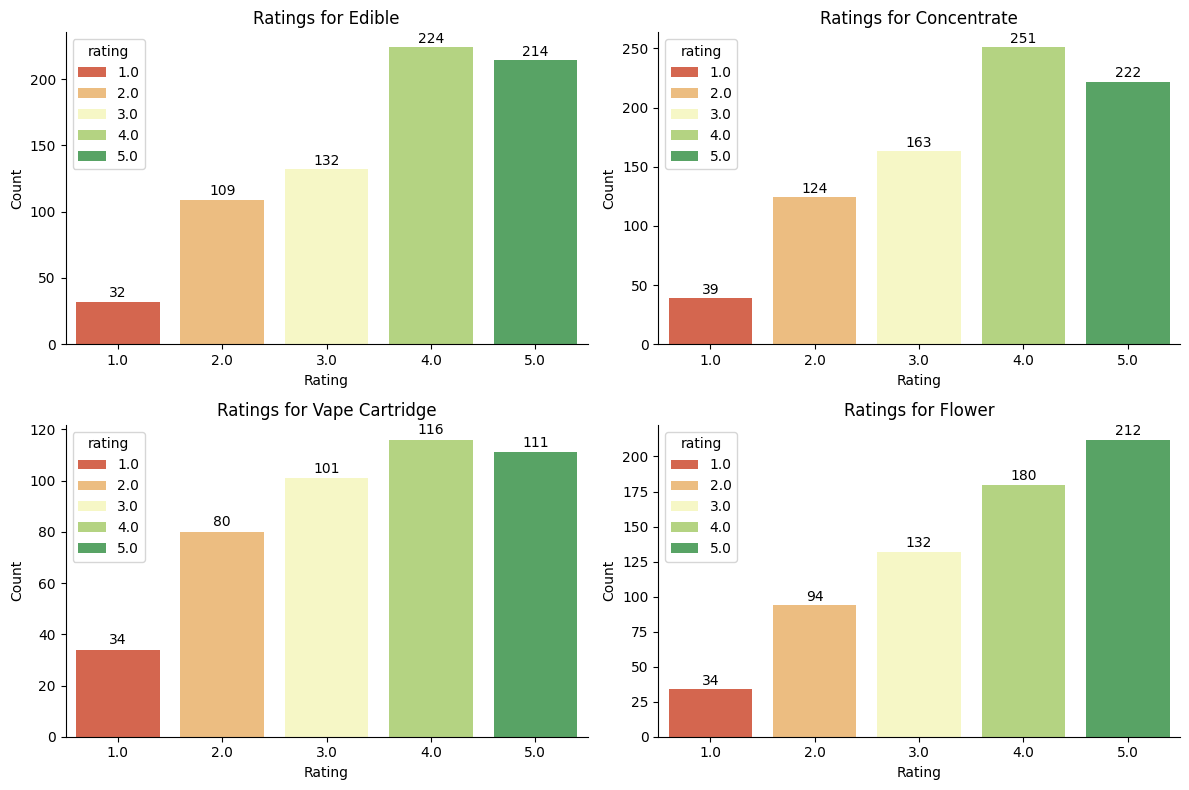

In [20]:

# group data by category then rating,
data = merged_df.groupby(['category', 'rating']).size().reset_index(name = 'count')

# get unique categories
categories = merged_df['category'].unique()


# create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # flatten 2x2 grid to a 1D array for easy looping

# loop through each category and plot
for i, cat in enumerate(categories):
    cat_data = data[data['category'] == cat]
    ax = sns.barplot(x = 'rating', y = 'count', data = cat_data, hue = 'rating',
                palette = rating_colors, ax = axes[i])
    axes[i].set_title(f'Ratings for {cat}')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Count')

    # add counts on top of bars
    for p in ax.patches:
      height = p.get_height()
      if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x-pos: bar start at x-axis then get wideth divide by two to get center of bar
            height + 1,                     # y-pos: just above bar
            int(height),                    # label as integer
            ha = 'center',                   # horizontal alignment
            va = 'bottom'                    # vertical alignment
        )

    # remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Ratings Distribution by Strain Type

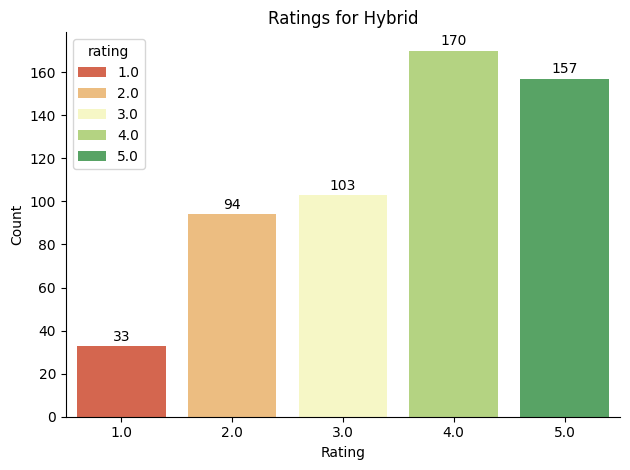

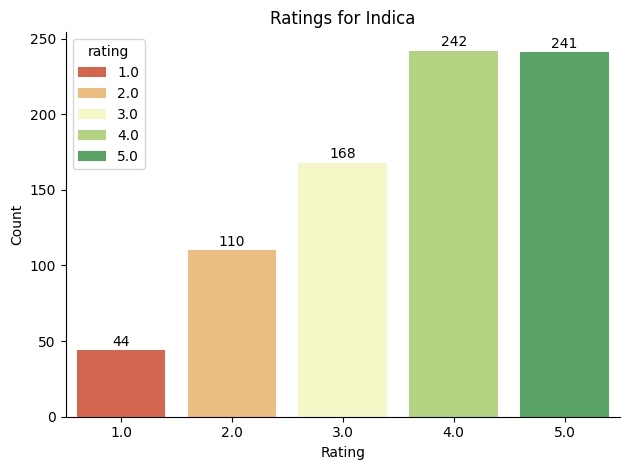

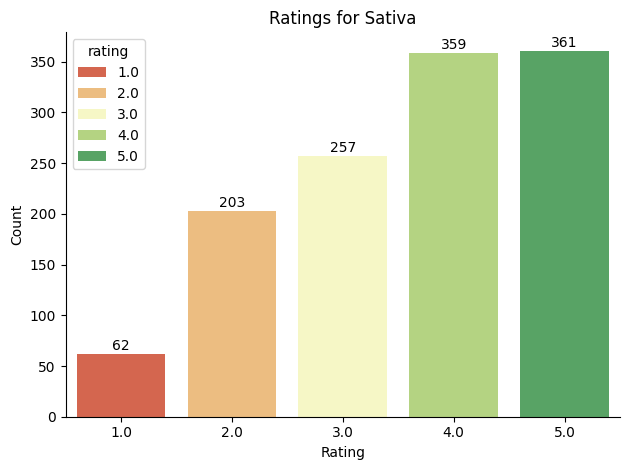

In [21]:
# group data by strain type then rating
data = merged_df.groupby(['strain_type', 'rating']).size().reset_index(name = 'count')

# get unique strain types
strain_types = merged_df['strain_type'].unique()

for stype in strain_types:
    stype_data = data[data['strain_type'] == stype]
    ax = sns.barplot(x = 'rating', y = 'count', data = stype_data,
                     hue = 'rating', palette = rating_colors)

    ax.set_title(f'Ratings for {stype}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2,
                height + 1,
                int(height),
                ha='center',
                va='bottom' )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


### Event Type Distribution

Counts of view, click, save, cart, and buy

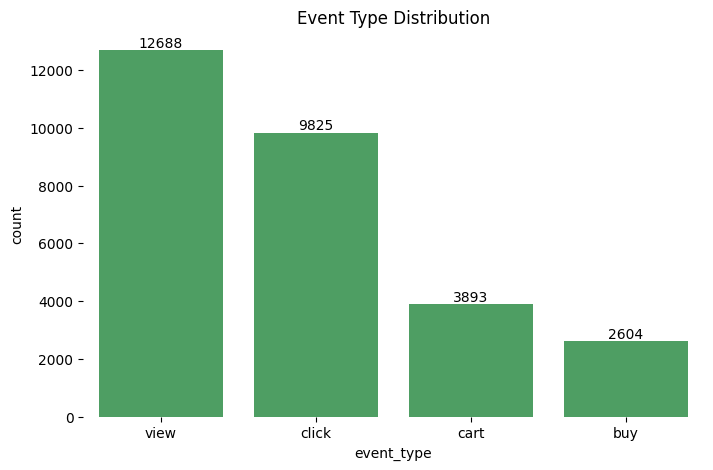

In [22]:
plt.figure(figsize = (8,5))
ax = sns.countplot(x = 'event_type', color = '#41ab5d', data = merged_df)
plt.title('Event Type Distribution')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 1,
            int(height),
            ha = 'center',
            va = 'bottom')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

### Category Counts for Product

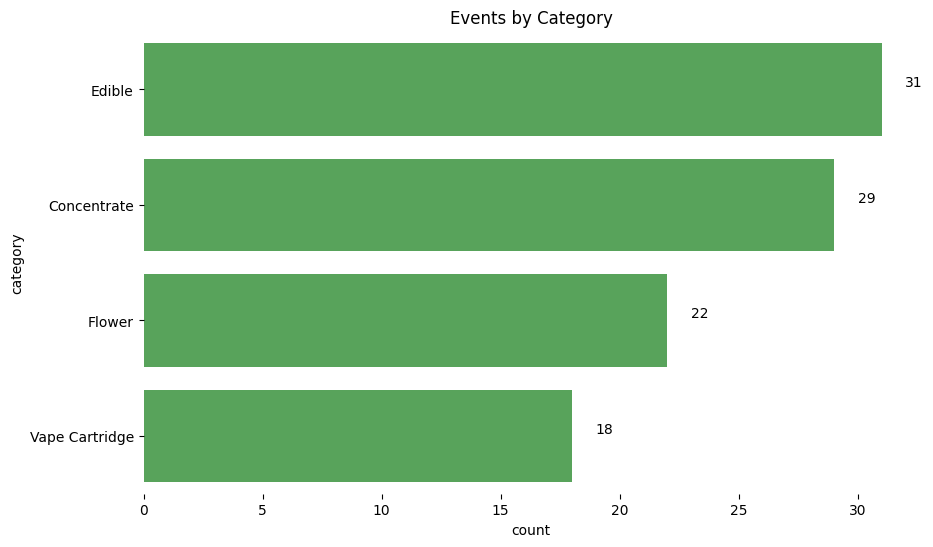

In [23]:
plt.figure(figsize=(10,6))
ax = sns.countplot(y = 'category', data = products_df, color = '#4CAF50',
              order = products_df['category'].value_counts().index)
plt.title('Events by Category')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(
            width + 1,
            p.get_y() + p.get_height() / 2, # middle of bar vertically
            int(width),
            ha = 'left',
            va = 'bottom')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

### Category Counts for All User Session


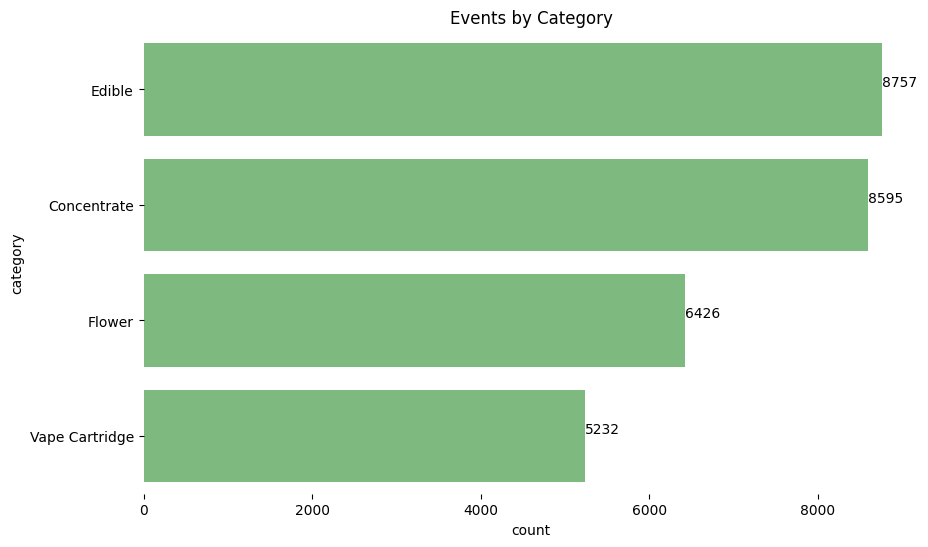

In [24]:
plt.figure(figsize=(10,6))
ax = sns.countplot(y = 'category', data = merged_df, color = '#74c476',
              order = merged_df['category'].value_counts().index)
plt.title('Events by Category')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(
            width + 1,
            p.get_y() + p.get_height() / 2, # middle of bar vertically
            int(width),
            ha = 'left',
            va = 'bottom')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

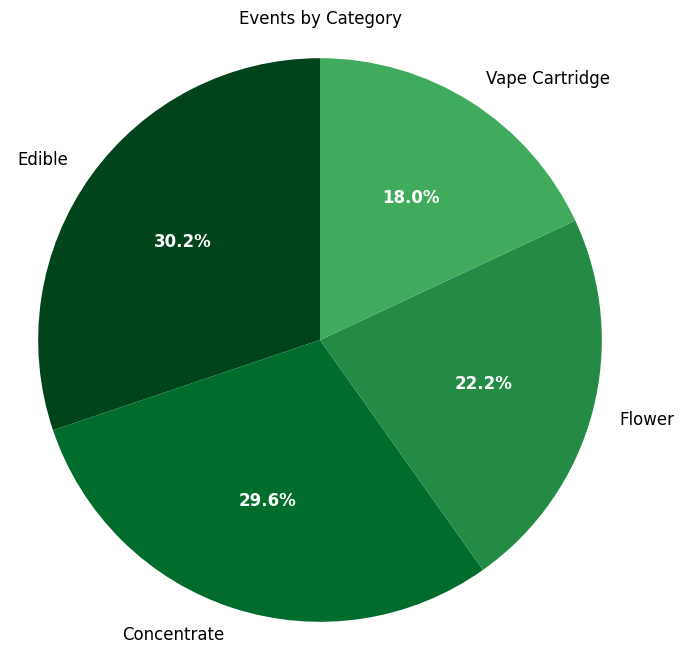

In [25]:
# get counts per category
category_counts = merged_df['category'].value_counts()

# colors
colors = ['#00441b', '#006d2c', '#238b45', '#41ab5d']

# create pie chart
plt.figure(figsize = (8,8))
wedges, texts, autotexts = plt.pie(
    category_counts,
    labels = category_counts.index,
    autopct = '%1.1f%%',
    startangle = 90,
    colors = colors )

# customize autopct text (percentages inside slices)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# customize slice labels
for label in texts:
    label.set_color('black')  # keep labels black
    label.set_fontsize(12)


plt.title('Events by Category')
plt.axis('equal')  # make pie circle, not ellipse
plt.show()

### Price Distribution and Sensitivity

#### Overall Product Price Distribution

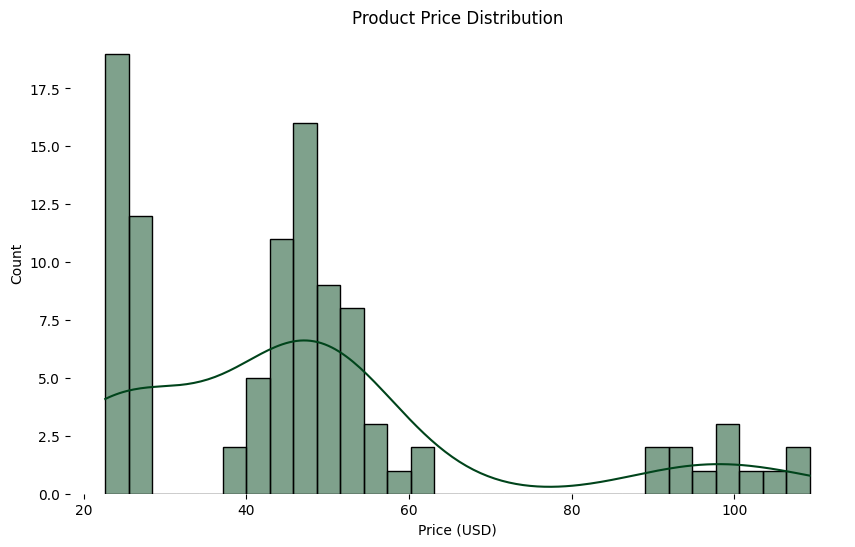

In [26]:
# price histogram overall and by category

plt.figure(figsize = (10,6))
ax = sns.histplot(products_df['price_usd'], bins = 30, kde = True, color = "#00441b")
plt.title("Product Price Distribution")
plt.xlabel("Price (USD)")

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

#### Expensive Products

In [27]:
# expensive products

expensive_products = products_df[products_df['price_usd'] > 80]

print(expensive_products)

   product_id                   name category strain_type              strain  \
4        p005       Sour Diesel - 7g   Flower      Sativa         Sour Diesel   
9        p010      Wedding Cake - 7g   Flower      Indica        Wedding Cake   
10       p011        Lemon Cherry 7g   Flower      Sativa        Lemon Cherry   
11       p012             OG Kush 7g   Flower      Sativa             OG Kush   
14       p015             OG Kush 7g   Flower      Hybrid             OG Kush   
21       p022      Ice Cream Cake 7g   Flower      Hybrid      Ice Cream Cake   
36       p037  Girl Scout Cookies 7g   Flower      Indica  Girl Scout Cookies   
37       p038      CA Gold Rush - 7g   Flower      Indica        CA Gold Rush   
51       p052  Girl Scout Cookies 7g   Flower      Indica  Girl Scout Cookies   
69       p070        CA Gold Rush 7g   Flower      Sativa        CA Gold Rush   
78       p079        CA Gold Rush 7g   Flower      Sativa        CA Gold Rush   
82       p083  Girl Scout Co

In [28]:
# show columns: product_id, name, category, price_usd and sort by price
products_sorted = products_df.sort_values(by = 'price_usd', ascending = False)

# Select only these 4 columns
products_sorted[['product_id', 'name', 'category', 'price_usd']]

,product_id,name,category,price_usd
69,p070,CA Gold Rush 7g,Flower,109.29
21,p022,Ice Cream Cake 7g,Flower,108.81
78,p079,CA Gold Rush 7g,Flower,103.69
82,p083,Girl Scout Cookies 7g,Flower,101.34
9,p010,Wedding Cake - 7g,Flower,99.45
...,...,...,...,...
59,p060,Lemon Cherry - 100g,Edible,23.02
38,p039,CA Gold Rush 200g,Edible,22.86
54,p055,Sour Diesel 100g,Edible,22.84
98,p099,Green Crack 50 pieces,Edible,22.76


The top 5 expensive products in our catalog are flowers costing more than $99.

#### Price Distribution by Category

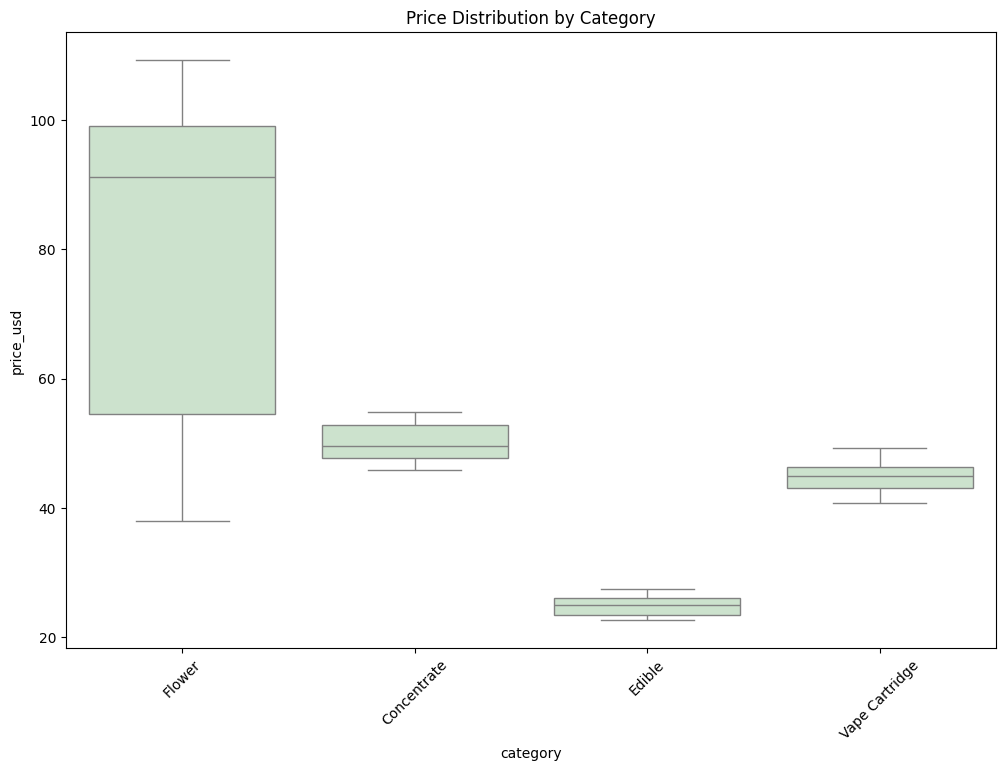

In [29]:
plt.figure(figsize = (12,8))
sns.boxplot(data = products_df, x = 'category',
            y = 'price_usd', color = '#C8E6C9' )
plt.title("Price Distribution by Category")
plt.xticks(rotation = 45)
plt.show()

The box plots show that flowers have the most expensive products with the most variance, whereas concentrates and vape cartridges are about similar in price while edibles are the least expensive products.

Histogram of all four product prices

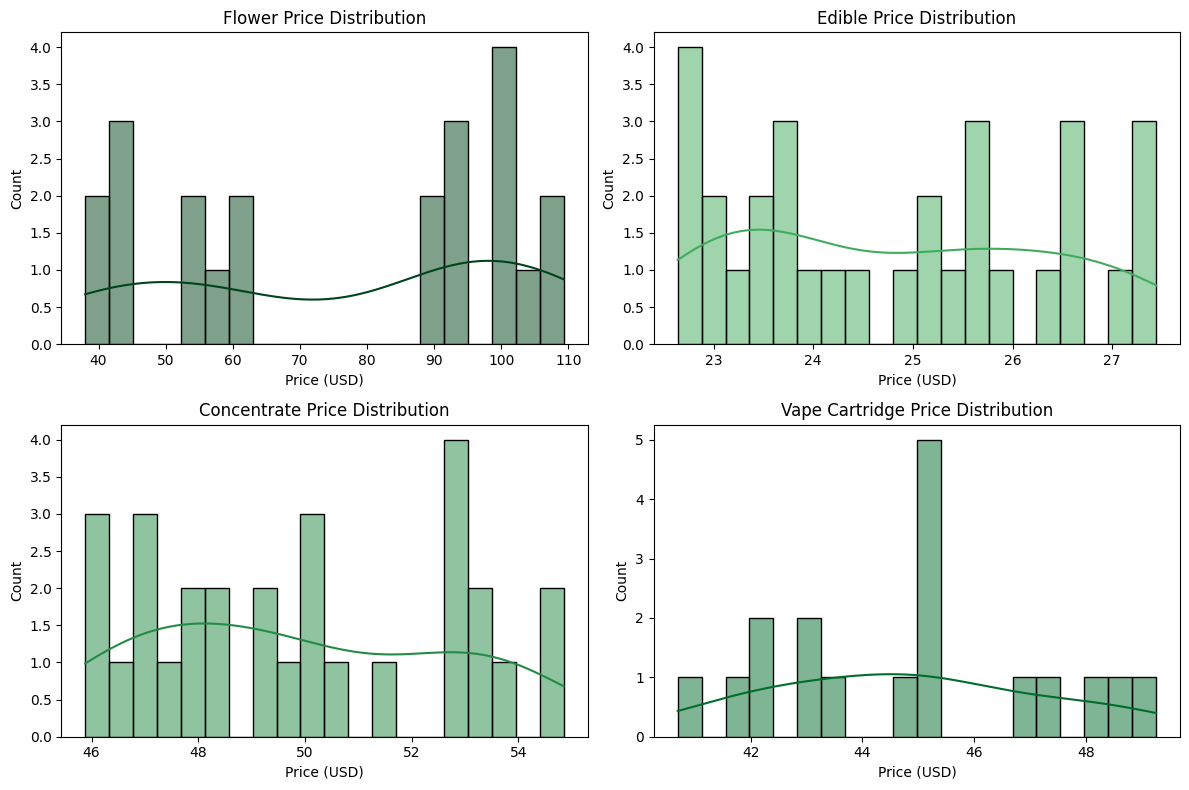

In [30]:
# filter only the four product types
product_types = ['Flower', 'Edible', 'Concentrate', 'Vape Cartridge']
filtered_df = products_df[products_df['category'].isin(product_types)]

# choose a different color for each category
colors = ['#00441b', '#41ab5d', '#238b45', '#006d2c']

# create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# loop through product types and plot histograms
for i, product_type in enumerate(product_types):
    subset = filtered_df[filtered_df['category'] == product_type]
    sns.histplot(
        data = subset,
        x = 'price_usd',
        bins = 20,
        kde = True,
        ax = axes[i],
        color = colors[i],
        edgecolor = 'black'
    )
    axes[i].set_title(f'{product_type} Price Distribution')
    axes[i].set_xlabel('Price (USD)')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


Purchase Quantity Distribution (Only for Buy Events)

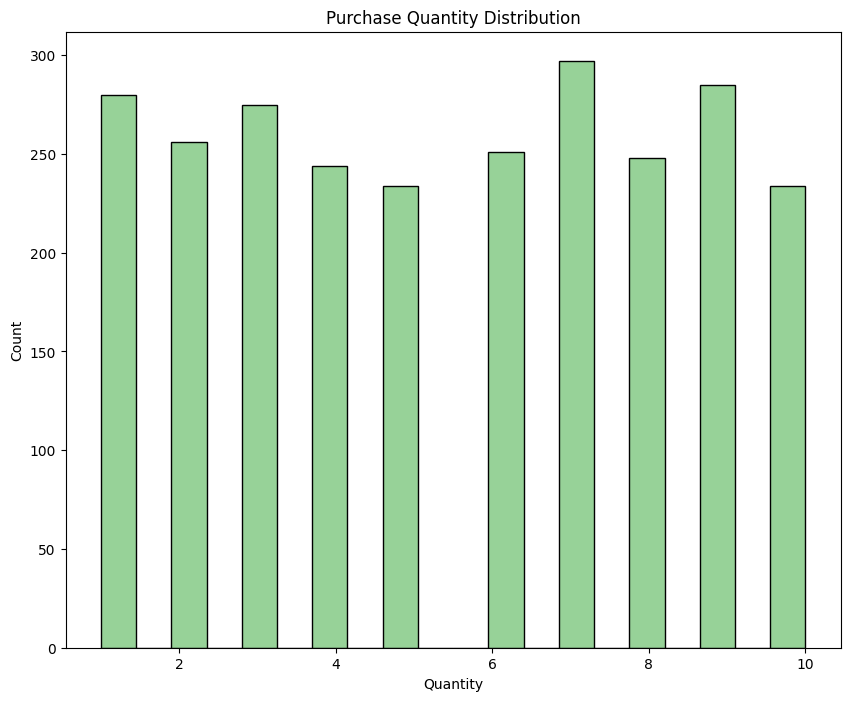

In [31]:
purchase_qty = merged_df[merged_df['event_type'] == 'buy']['quantity']
plt.figure(figsize = (10, 8))
ax = sns.histplot(purchase_qty, bins = 20, color = "#74c476")

# remove grid lines
ax.grid(False)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Purchase Quantity Distribution")
plt.xlabel("Quantity")
plt.show()

## 4d. Aggregations

### Conversion Funnel: Click -> Cart/Save/None -> Buy

In [32]:
# unique users
total_users = merged_df['user_id'].nunique()

# count all who clicked a product
click_users = merged_df[merged_df['event_type'] == 'click']['user_id'].nunique()

# count all who saved a product
save_users = merged_df[merged_df['event_type'] == 'save']['user_id'].nunique()

# count all who added something to their cart
cart_users_set = set(merged_df[merged_df['event_type'] == 'cart']['user_id'])

# count all who bought something
buy_users_set = set(merged_df[merged_df['event_type'] == 'buy']['user_id'])

# & -> users have to be in both to be a buy user because they have to go through cart
buy_users_set = buy_users_set & cart_users_set

cart_users = len(cart_users_set)
buy_users = len(buy_users_set)

Penetration Rates

In [33]:
# penetration rates (share of all users)
click_penetration = click_users / total_users * 100
cart_penetration = cart_users / total_users * 100
buy_penetration = buy_users / total_users * 100

print("=== Penetration Rates (of all unique users) ===")
print(f"\nClicked product:   {click_penetration:.2f}%\n")
print(f"Added to cart:     {cart_penetration:.2f}%\n")
print(f"Purchased:         {buy_penetration:.2f}%")

=== Penetration Rates (of all unique users) ===

Clicked product:   100.00%

Added to cart:     95.90%

Purchased:         90.70%


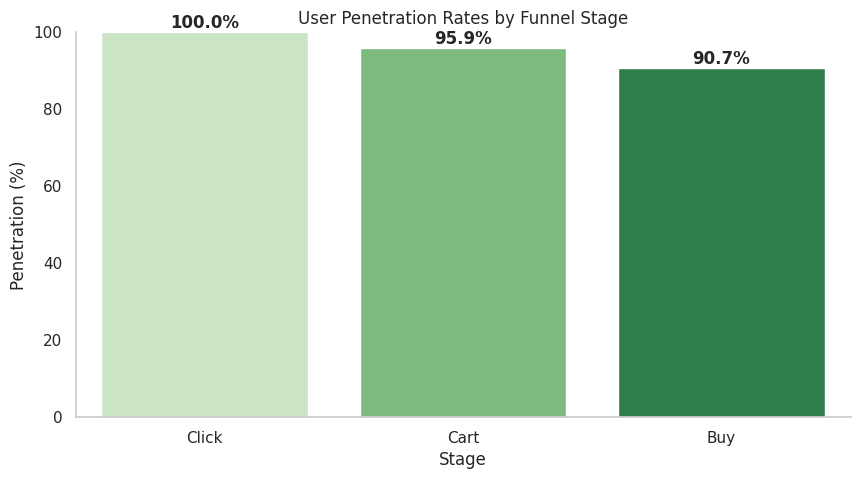

In [34]:
# create df for penetration rates
penetration_df = pd.DataFrame({
    "Stage": ["Click", "Cart", "Buy"],
    "Penetration (%)": [click_penetration, cart_penetration, buy_penetration]
})

# set seaborn style
sns.set(style = "whitegrid")

# plot penetration rates
plt.figure(figsize = (10, 5))
ax = sns.barplot(
    x = "Stage", y = "Penetration (%)", hue = "Stage",
    data = penetration_df, palette = "Greens", dodge = False)

# remove grid lines
ax.grid(False)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set title and y-axis limits
plt.title("User Penetration Rates by Funnel Stage")
plt.ylim(0, 100)

# add percentage labels
for i, v in enumerate(penetration_df["Penetration (%)"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha = 'center', fontweight = 'bold')

plt.show()

---
**Penetration Rate:**

---

Penetration rate measures the percentage of users who interacted with a product at least once relative to the total user base. In this dataset:

 - Clicks: 100% of users clicked on at least one product.

 - Added to Cart: 96% of users clicked and then added a product to their cart.

 - Buy: 90.7% of users who clicked eventually purchased a product.

These numbers show how widely users engaged with the product at each stage.

Funnel Conversion Rates

In [35]:
# funnel conversion rates (share of previous step)
click_to_cart_rate = cart_users / click_users * 100 if click_users else 0
cart_to_buy_rate = buy_users / cart_users * 100 if cart_users else 0

print("=== Funnel Conversion Rates ===")
print(f"\nClick → Cart: {click_to_cart_rate:.2f}%\n")
print(f"Cart → Buy:   {cart_to_buy_rate:.2f}%")

=== Funnel Conversion Rates ===

Click → Cart: 95.90%

Cart → Buy:   94.58%


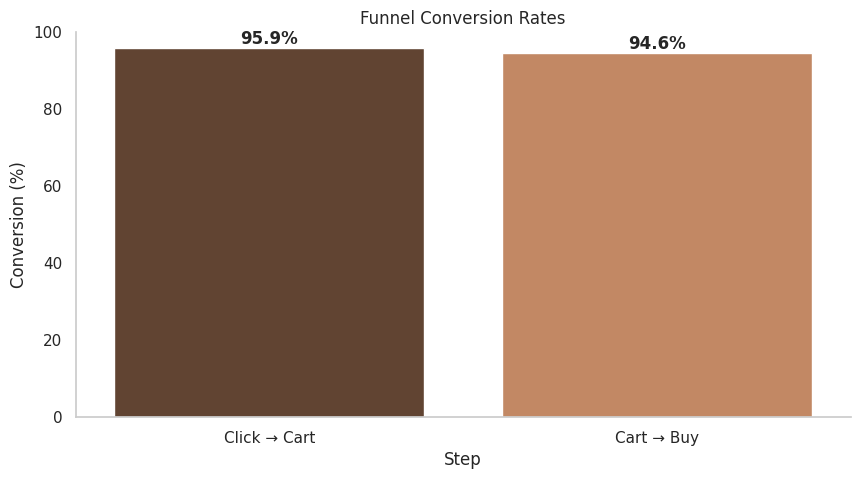

In [36]:
# create df for funnel conversion rates
conversion_df = pd.DataFrame({
    "Step": ["Click → Cart", "Cart → Buy"],
    "Conversion (%)": [click_to_cart_rate, cart_to_buy_rate] })

# plot funnel conversion rates
plt.figure(figsize = (10, 5))

ax = sns.barplot(
    x = "Step", y = "Conversion (%)", hue = "Step",
    data = conversion_df, palette = "copper", dodge = False)

# remove grid lines
ax.grid(False)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Funnel Conversion Rates")
plt.ylim(0, 100)
for i, v in enumerate(conversion_df["Conversion (%)"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha = 'center', fontweight = 'bold')
plt.show()

---
**Funnel Conversion Rate:**

---

Funnel conversion rate measures the percentage of users moving from one stage of the engagement or purchase funnel to the next. In this dataset:

 - Click → Cart: 96% of users who clicked also added the product to their cart.

 - Cart → Buy: 94.6% of users who added to cart went on to purchase.

These numbers indicate how efficiently users progress through each stage of the purchase funnel. High conversion rates suggest that most users who start interacting continue through to purchase.

### Avg Rating and Total Interactions per Category

In [37]:
category_summary = merged_df.groupby('category').agg(
    avg_rating = ('rating','mean'),
    total_clicks = ('event_type', lambda x: (x == 'click').sum()),
    total_cart = ('event_type', lambda x: (x == 'cart').sum()),
    total_buys = ('event_type', lambda x: (x == 'buy').sum()),
    total_saves = ('event_type', lambda x: (x == 'save').sum())
).reset_index().sort_values(by = 'total_clicks', ascending = False)

print("\nCategory summary:\n", category_summary)


Category summary:
          category  avg_rating  total_clicks  total_cart  total_buys  \
1          Edible    3.673699          2975        1167         711   
0     Concentrate    3.617021          2902        1186         799   
2          Flower    3.677914          2161         838         652   
3  Vape Cartridge    3.429864          1787         702         442   

   total_saves  
1            0  
0            0  
2            0  
3            0  


The category wiht the highest total clicks are edibles with almost 3000 clicks followed by concentrates at 2900, then flowers at 2100, and finally vape cartirdges at 1800.

The category with the most buys are concentrates at 800 purchases followed by edibles at 700, then flowers at 650, and finally vape cartridges at 450.

The category with the highest average rating are flowers at 3.68 followed closely by edibles at 3.67. Concentrates had an average rating of 3.62 and vape cartridges had the least average rating with 3.43.

### Top 10 Products

In [38]:
# get counts per product for 'buy' events
buy_counts = (
    merged_df[merged_df['event_type'] == 'buy']
    .groupby('product_id')
    .size()
    .sort_values(ascending = False) )

# get the 10th highest value
top10_cutoff = buy_counts.iloc[9]  # the 10th product's count

# keep all products with count >= cutoff
top_products = buy_counts[buy_counts >= top10_cutoff]

print("\nTop 10 (with ties) purchased products:\n", top_products)



Top 10 (with ties) purchased products:
 product_id
p026    43
p065    41
p067    41
p096    41
p093    40
p051    40
p097    39
p077    38
p050    38
p001    38
p003    38
dtype: int64


In [39]:
# select col from prod_df to print
products_db = products_df[['product_id', 'name', 'vendor', 'category']].drop_duplicates()

# select the product details from products_db that matches the product id in top products
top_product_details = products_db[products_db['product_id'].isin(top_products.index)]

# add set index to product id and add the purchase counts as a column
top_product_details = top_product_details.set_index('product_id')
top_product_details['purchase_count'] = top_products

# reorder columns
top_product_details = top_product_details[['purchase_count', 'name', 'vendor', 'category']]

# sort by purchase_count descending
top_product_details = top_product_details.sort_values(by = 'purchase_count', ascending = False)

print()
print("\nTop 10 (with ties) purchased products:\n", top_product_details)



Top 10 (with ties) purchased products:
             purchase_count                        name            vendor  \
product_id                                                                 
p026                    43            Maui Wowie 500mg  Elevate Extracts   
p065                    41           Jack Herer 1000mg     GreenLeaf Co.   
p067                    41     Girl Scout Cookies 3.5g   Sunset Wellness   
p096                    41  Girl Scout Cookies - 500mg      Herbal Haven   
p051                    40              OG Kush 1000mg  Elevate Extracts   
p093                    40       Wedding Cake One Gram      Happy Trails   
p097                    39     Girl Scout Cookies 200g  Elevate Extracts   
p001                    38                OG Kush 3.5g      Herbal Haven   
p003                    38         Blue Dream One Gram        Pure Bloom   
p050                    38          Maui Wowie - 500mg      Happy Trails   
p077                    38         CA Gold Rus

The top purchased product was a vape cartridge by Elevate Extracts of Maui Wowi 500mg with 43 purchases. The highest sold concentrate was the second most purchased product which was between Jack Herer 1000mg by GreenLeaf Co. and Girl Scout Cookies - 500mg by Herbal Haven. The highest sold flower was also tied for the second most purchased product and that was Girl Scout Cookies 3.5g by Sunset Wellness. Concentrates accounted for five of the top 10 (with ties resulting in 11 items), flowers accounted for three, vape cartridges accounted for two, and finally one edible.

### Top 3 Products In Each Category

In [40]:
top_n = 3  # top N products per category
categories = merged_df['category'].unique()

products_db = merged_df[['product_id', 'name', 'vendor', 'category']].drop_duplicates()

for cat in categories:
    # filter for category with purchase event
    cat_df = merged_df[(merged_df['category'] == cat) & (merged_df['event_type'] == 'buy')]

    # count purchases per product
    buy_counts = cat_df.groupby('product_id').size().sort_values(ascending = False)

    # if category has no purchase print no purhcases
    if len(buy_counts) == 0:
        print(f"\nCategory '{cat}' has no purchased products.")
        continue

    # determine cutoff for top N (handle ties)
    cutoff_idx = min(top_n-1, len(buy_counts)-1)  # in case fewer than N products
    top_cutoff = buy_counts.iloc[cutoff_idx]

    top_products = buy_counts[buy_counts >= top_cutoff]

    # merge with product info, set indext to prod id, add buy count col, reoroder col
    top_product_details = products_db[products_db['product_id'].isin(top_products.index)]
    top_product_details = top_product_details.set_index('product_id')
    top_product_details['purchase_count'] = top_products
    top_product_details = top_product_details.reset_index()
    top_product_details = top_product_details[['purchase_count', 'name', 'vendor', 'category']]
    top_product_details = top_product_details.sort_values(by = 'purchase_count', ascending = False)

    print(f"\nTop {top_n} (with ties) purchased products in category '{cat}':\n", top_product_details)



Top 3 (with ties) purchased products in category 'Edible':
    purchase_count                     name            vendor category
0              39  Girl Scout Cookies 200g  Elevate Extracts   Edible
2              35   Purple Urcle 20 pieces       Bud Masters   Edible
1              34        Purple Urcle 100g      Happy Trails   Edible

Top 3 (with ties) purchased products in category 'Concentrate':
    purchase_count                        name            vendor     category
0              41  Girl Scout Cookies - 500mg      Herbal Haven  Concentrate
2              41           Jack Herer 1000mg     GreenLeaf Co.  Concentrate
1              40              OG Kush 1000mg  Elevate Extracts  Concentrate

Top 3 (with ties) purchased products in category 'Vape Cartridge':
    purchase_count                   name            vendor        category
1              43       Maui Wowie 500mg  Elevate Extracts  Vape Cartridge
2              40  Wedding Cake One Gram      Happy Trails  Vape C

## 4e. Time Based Analysis

### Events per Day

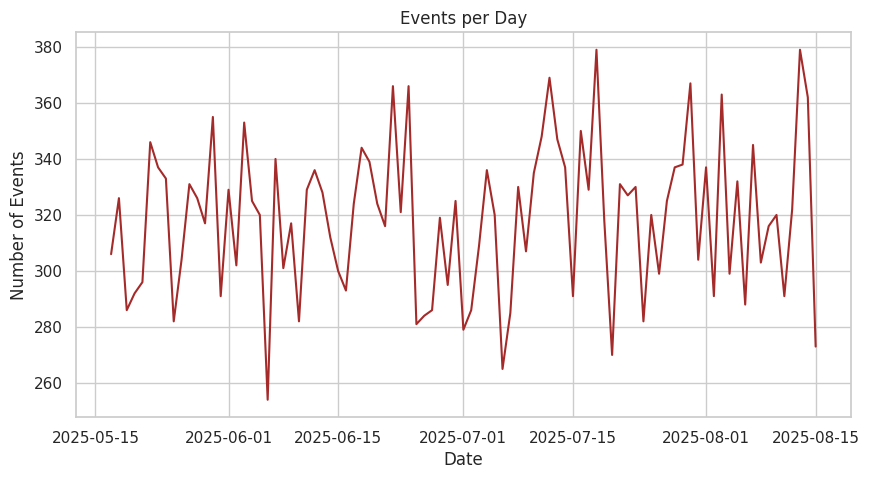

In [41]:
# convert timestamp column to datetime
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# extract the date
merged_df['date'] = merged_df['timestamp'].dt.date

# group by date
events_per_day = merged_df.groupby('date').size()

plt.figure(figsize = (10,5))
events_per_day.plot(color = "brown")
plt.title("Events per Day")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.show()

The daily time series shows no trend or seasonality as it appears very stochastic.

### Events by Hour

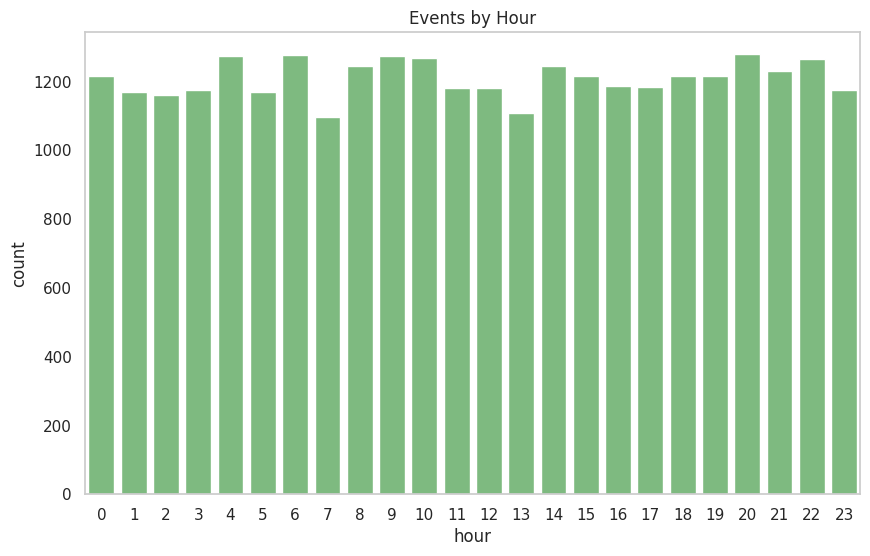

In [95]:
# extract hour to own col
merged_df['hour'] = merged_df['timestamp'].dt.hour

plt.figure(figsize = (10,6))
ax = sns.countplot(data = merged_df, x = 'hour', color = "#74c476")

# remove grid lines
ax.grid(False)

plt.title("Events by Hour")
plt.show()

### Events by Weekday

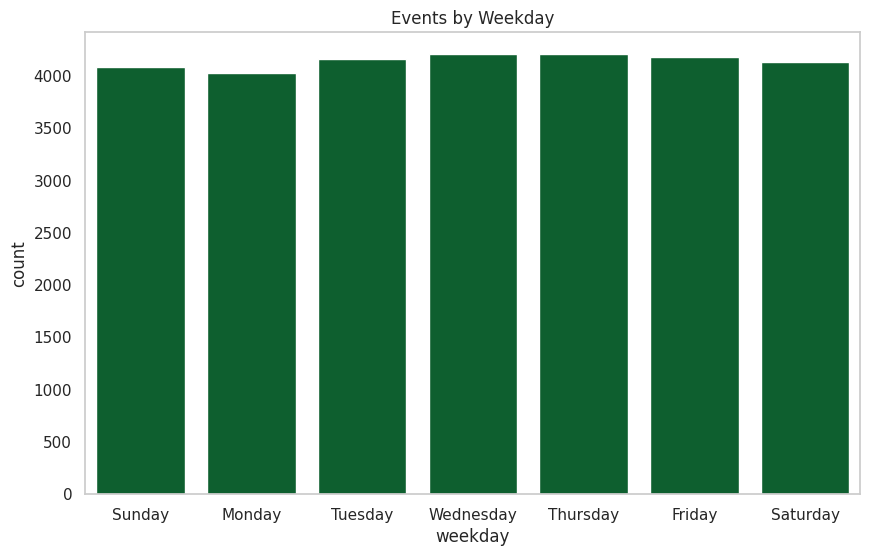

In [94]:
# extract weekday to own col
merged_df['weekday'] = merged_df['timestamp'].dt.day_name()

plt.figure(figsize = (10,6))
ax = sns.countplot(data = merged_df, x = 'weekday',
              order = ['Sunday', 'Monday','Tuesday','Wednesday','Thursday',
                       'Friday','Saturday'],
              color = "#006d2c")

# remove grid lines
ax.grid(False)

plt.title("Events by Weekday")
plt.show()

### Avg Time Between First and Last Event per User

In [44]:
# sort events by user and time so we can get differences
merged_df = merged_df.sort_values(['user_id', 'timestamp'])

# get the previous event timestamp for each user
merged_df['prev_timestamp'] = merged_df.groupby('user_id')['timestamp'].shift(1)

# get difference (in minutes) between current and previous event
merged_df['time_diff'] = (merged_df['timestamp'] - merged_df['prev_timestamp']).dt.total_seconds() / 60

# flag new session if time gap is more than 30 minutes
merged_df['new_session'] = merged_df['time_diff'] > 30

# create session ID by cumulatively summing new session flags per user
merged_df['session_id'] = merged_df.groupby('user_id')['new_session'].cumsum()

# calc session duration in minutes (max - min timestamp per session)
session_durations = merged_df.groupby(['user_id', 'session_id']).agg(
    session_length = ('timestamp', lambda x: (x.max() - x.min()).total_seconds() / 60))

# calc avg session length across all users and sessions
avg_session_length = session_durations['session_length'].mean()

print(f"Average session length: {avg_session_length:.2f} minutes")

Average session length: 6.41 minutes


## 4f. User Engagement

### Avg Events per User

In [45]:
events_per_user = merged_df.groupby('user_id').size()

# avg events per user
avg_events = events_per_user.mean()
print(f"Average events per user: {avg_events:.2f}")

Average events per user: 29.01


### Distribution of Events per User

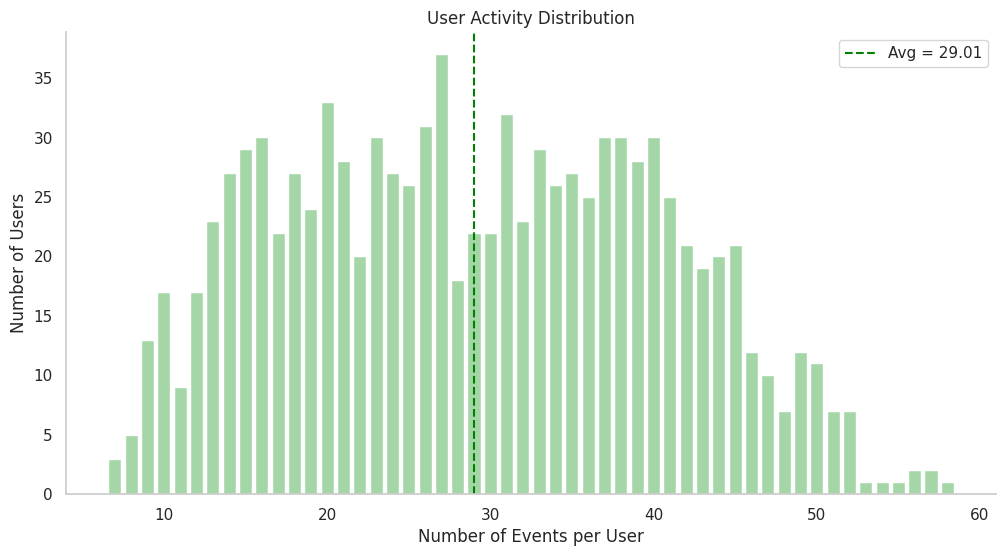

In [46]:
events_count = events_per_user.value_counts().sort_index()

fig, ax = plt.subplots(figsize = (12,6))

# use the actual event numbers as x
x = events_count.index
y = events_count.values
ax.bar(x, y, color = "#A5D6A7")

ax.axvline(x = avg_events, color = 'green', linestyle='--',
           label=f"Avg = {avg_events:.2f}")
ax.legend()

# remove gridlines
ax.grid(False)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# labels and title
ax.set_xlabel("Number of Events per User")
ax.set_ylabel("Number of Users")
ax.set_title("User Activity Distribution")
plt.show()

In [47]:
buyer_frequency = merged_df[merged_df['event_type']=='buy'].groupby('user_id').size()
print("Average purchase frequency per user:", buyer_frequency.mean())

Average purchase frequency per user: 2.8710033076074972


In [48]:
# Replace 'u0763' with the user_id you want to inspect
user_id_to_check = 'u0501'

# Filter the DataFrame
user_data = merged_df[merged_df['user_id'] == user_id_to_check]

# Or display nicely in Jupyter Notebook
user_data_filtered = user_data[['product_id', 'event_type', 'timestamp', 'quantity', 'name', 'category']]
user_data_filtered

,product_id,event_type,timestamp,quantity,name,category
946,p062,view,2025-05-20 02:34:51.889440,NaN,Blue Dream 500mg,Concentrate
4437,p067,view,2025-05-31 00:26:52.889478,NaN,Girl Scout Cookies 3.5g,Flower
4439,p067,click,2025-05-31 00:29:52.889478,NaN,Girl Scout Cookies 3.5g,Flower
4442,p067,click,2025-05-31 00:33:52.889478,NaN,Girl Scout Cookies 3.5g,Flower
7450,p004,view,2025-06-09 14:58:28.889398,NaN,Sour Diesel - 50 pieces,Edible
11998,p050,view,2025-06-23 18:16:11.889406,NaN,Maui Wowie - 500mg,Concentrate
26092,p029,view,2025-08-06 23:31:52.889448,NaN,Maui Wowie 1000mg,Concentrate
27847,p028,view,2025-08-12 12:17:27.889456,NaN,Ice Cream Cake One Gram,Concentrate
27848,p028,click,2025-08-12 12:19:27.889456,NaN,Ice Cream Cake One Gram,Concentrate
27849,p028,cart,2025-08-12 12:22:27.889456,10.0,Ice Cream Cake One Gram,Concentrate


In [49]:
unique_buyers = merged_df[merged_df['event_type'] == 'buy']['user_id'].nunique()
print(f"Number of unique buyers: {unique_buyers}")

Number of unique buyers: 907


In [50]:
repeat_buyers = buyer_frequency[buyer_frequency > 1]  # keep only users with more than 1 purchase
print("Number of repeat buyers:", len(repeat_buyers))
print("Average purchase frequency among repeat buyers:", repeat_buyers.mean())

Number of repeat buyers: 709
Average purchase frequency among repeat buyers: 3.393511988716502


In [51]:
repeat_purchase_counts = merged_df[merged_df['event_type']=='buy'].groupby(['user_id', 'product_id']).size()
repeat_purchase_users = repeat_purchase_counts[repeat_purchase_counts > 1].reset_index()['user_id'].nunique()
repeat_purchase_rate = repeat_purchase_users / unique_buyers * 100
print(f"Repeat Purchase Rate per Product: {repeat_purchase_rate:.2f}%")

Repeat Purchase Rate per Product: 0.00%


# 5.0 Feature Engineering

For products:
- extract or encode categorical features
- compute summary stats like avg rating, total sales volume
- generate text embeddings from product names/descriptions for NLP or similarity modeling.

For user behavior:
- aggregate user interactions into features per user-product pair (e.g., total views, last purchase date)
- build user profiles or segmentations (e.g., frequent buyers, browsers)

### 5a. User-Product Interaction Features

`total_interactions` gives a single engagment score for collaborative filtering or similarity weighting while counting each event separately helps feature richness for ML models

In [52]:
# weighted interaction score: click = 1, cart = 2, save = 2, buy = 5
event_weight = {'click':1, 'cart':2, 'save':2, 'buy':5}
merged_df['interaction_score'] = merged_df['event_type'].map(event_weight)

# aggregate per user-product
user_product_features = merged_df.groupby(['user_id','product_id']).agg(
    total_interactions=('interaction_score','sum'),
    num_clicks=('event_type', lambda x: (x=='click').sum()),
    num_cart=('event_type', lambda x: (x=='cart').sum()),
    num_buy=('event_type', lambda x: (x=='buy').sum()),
    num_save=('event_type', lambda x: (x=='save').sum()),
    avg_rating=('rating','mean'),
    last_interaction=('timestamp','max')
).reset_index()


### 5b. User Features

- Summarize aech user's overall behavior

- Helps segment users (heavy buyers, browsers)

- Avg rating can be used for personalized predictions

In [53]:
# calc a col called spent to figure out cumulative user expense during dataset
merged_df['spent'] = merged_df.apply(
    lambda row: row['price_usd'] * row['quantity'] if row['event_type'] == 'buy' and row['quantity'] else 0, axis = 1)

In [54]:
user_features = merged_df.groupby('user_id').agg(
    total_clicks = ('event_type', lambda x: (x=='click').sum()),
    total_cart = ('event_type', lambda x: (x=='cart').sum()),
    total_buy = ('event_type', lambda x: (x=='buy').sum()),
    total_save = ('event_type', lambda x: (x=='save').sum()),
    avg_rating_given = ('rating','mean'),
    total_spent = ('spent','sum') ).reset_index()

### 5c. Product Features

- Summarizing product characteristics for modeling and content based recommendations

- Total buys and saves can help indicate popularity

In [55]:
# product-level aggregated features
product_features = merged_df.groupby('product_id').agg(
    category = ('category','first'),
    strain_type = ('strain_type','first'),
    avg_price = ('price_usd','mean'),
    avg_thc = ('THC_pct','mean'),
    avg_cbd = ('CBD_pct','mean'),
    avg_rating = ('rating','mean'),
    total_buys = ('event_type', lambda x: (x=='buy').sum()),
    total_saves = ('event_type', lambda x: (x=='save').sum()) ).reset_index()

### 5d. Time-Based Features

- Captures temporal patterns

- Recency can improve recommendation ranking (RFM-style features)

In [56]:
# interaction recency: days since last interaction per user-product
current_date = datetime.now()
user_product_features['days_since_last'] = (
    current_date - user_product_features['last_interaction']).dt.days

### 5e. Text Features (for NLP / Embeddings)

- For building text-based similarity

- `product_text_matrix` can be used to compute cosine similarity between products

In [57]:
# combine product name, strain_type, category, description, and tags for embeddings
products_df['text_feature'] = products_df[
    ['name', 'strain_type', 'category', 'description', 'tags']
].fillna('').agg(' '.join, axis = 1)

# semantic similarity
# turn product text into numeric vectors; rows = prod, col = top 500 terms
# values are importance of term to prod
tfidf = TfidfVectorizer(max_features = 500)
product_text_matrix = tfidf.fit_transform(products_df['text_feature'])

# store feature names for interpretation if needed
product_feature_names = tfidf.get_feature_names_out()

### 5f. Collaborative Filtering

Algorithm predicts the missing pieces based on what similar users or similar products are doing

In [58]:
user_item_matrix = user_product_features.pivot(
    index = 'user_id',
    columns = 'product_id',
    values = 'total_interactions').fillna(0)

# 6.0 Modeling

Purchase Propensity:

- predict likelihood of purchase given prior behavior and product attributes

We aim to model users’ browsing behaviors to forecast which users are likely to convert into buyers. The ultimate goal is to identify high-propensity buyers and target them with tailored recommendations that drive purchases.

When evaluating our models, we will focus on the recall metric which measures how well the model indentifies all the positive cases. Recall answers the question: out of all users who would actually make a purchase, what fraction does our model correctly identify? Missing potential buyers carries a much higher opportunity cost than incorrectly targeting users with personalized recommendations. Additionally, false positives are less harmful in this context, since the recommendations are intended to generate leads and encourage conversions.

## 6a. Purchase Propensity: Classification Model with Logistic Regression, Random Forest, and XGBoost

### Prepare the models

Check for class imbalance and if there are we need to correct them otherwise there will be bias.

In [59]:
# count event distribution
event_counts = merged_df['event_type'].value_counts(normalize = True)

print(event_counts)


event_type
view     0.437366
click    0.338676
cart     0.134195
buy      0.089762
Name: proportion, dtype: float64


Since `buy` is less than 10% (0.0898), it indicates there is a class imbalance.

Create target variable

For classification, we'll use `1 = buy` and `0 = not buy`

In [60]:
# binary target column, True = 1, False = 0
merged_df['is_buy'] = (merged_df['event_type'] == 'buy').astype(int)

Select features
  - numerical feats: price, thc_pct, cbd_pct
  - categorical feats encoded: category, strain_type
  - behavioral feats: user-level aggregates

In [61]:
# simple features first
X = merged_df[['price_usd', 'THC_pct', 'category', 'strain_type']]

# target
y = merged_df['is_buy']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y)

Scale features and handle categorical encoding using `ColumnTransformer`

In [62]:
num_features = ['price_usd', 'THC_pct']
cat_features = ['category', 'strain_type']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_features) ])

### Logistic Regression

In [63]:
log_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter = 1000, class_weight = 'balanced')) ])

log_reg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price_usd', 'THC_pct']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category',
                                                   'strain_type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

### Random Forest

In [64]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators = 200, class_weight = 'balanced'))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price_usd', 'THC_pct']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category',
                                                   'strain_type'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200))])

### XGBoost Classifier

In [65]:
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        n_estimators = 300,
        learning_rate = 0.1,
        max_depth = 6,
        scale_pos_weight =
         (y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
    ))
])

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price_usd', 'THC_pct']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category',
                                                   'strain_type'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_r...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 6b. Preliminary Classification Evaluation

In [66]:
for model, name in [(log_reg_model, "Logistic Regression"),
                    (rf_model, "Random Forest"),
                    (xgb_model, "XGBoost")]:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.92      0.50      0.65      5281
           1       0.10      0.55      0.17       521

    accuracy                           0.51      5802
   macro avg       0.51      0.53      0.41      5802
weighted avg       0.85      0.51      0.61      5802

ROC-AUC: 0.5283257511355124

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.92      0.42      0.58      5281
           1       0.10      0.62      0.17       521

    accuracy                           0.44      5802
   macro avg       0.51      0.52      0.37      5802
weighted avg       0.84      0.44      0.54      5802

ROC-AUC: 0.5332486976634812

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.92      0.37      0.53      5281
           1       0.10      0.68      0.17       521

    accuracy                           0.40      5802
   m

1. What the results tell us

 - Class 0 (non-purchase) dominates. Precision is very high (0.92), meaning when the model predicts "no purchase," it’s almost always right.

 - Class 1 (purchase) suffers. Precision is 0.10 (lots of false positives), but recall is surprisingly high (0.55–0.68). That means the models are catching over half of actual purchases, but they’re also mislabeling many non-purchases as purchases.

 - Accuracy (~40–51%) isn’t meaningful here because the dataset is imbalanced.

 - ROC-AUC (~0.53) is barely above random guessing (0.50), so the models don’t separate the classes well.

2. Why this happens

 - Huge class imbalance (5,281 vs. 521). Purchases are only ~9% of the data.

 - Likely features aren’t strong enough yet to distinguish purchase from non-purchase.

 - Logistic Regression struggles with nonlinearities, while RF and XGBoost found more recall but at the cost of precision.

3. Next steps to improve

 - Handle imbalance better

    - Instead of just class_weight, try SMOTE (Synthetic Minority Oversampling Technique) to upsample purchase events.

    - Alternatively, undersample the majority class (non-purchases).

 - Feature engineering

    - Add more user-level history: e.g., of prior clicks before purchase

    - Add product attributes: THC%, category, strain type, rating, etc.

    - Add interaction features: user-product frequency, average session activity.

 - Model tuning

    - Logistic regression may not be powerful enough here → Random Forest & XGBoost need hyperparameter tuning (grid search or randomized search).

    - Use probability thresholds: Right now default is 0.5. If you lower it (e.g., 0.3), you’ll catch more purchases (boost recall).

  - Evaluation metric

    - Accuracy isn’t useful here.
      Use:
        - Precision-Recall AUC (better for imbalance)

        - F2-score (weights recall higher, which is useful if missing purchases is costly).

## 6c. SMOTE & Hyperparamter Tuning

 - Balance the classes with SMOTE so the models get enough exposure to the minority class.

 - Run Logistic Regression, Random Forest, and XGBoost again, but this time we’ll include hyperparameter tuning (via GridSearchCV).

 - Compare results (precision, recall, F1, ROC-AUC) to see whether balancing and tuning improve the models.

### Applying SMOTE

Identify categorical and numeric columns

In [67]:
categorical_cols = X.select_dtypes(include = ['object']).columns
numeric_cols = X.select_dtypes(exclude = ['object']).columns

Preprocess pipeline

In [68]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)])

Train Test split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                    random_state = 42)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

SMOTE on training data

In [70]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: is_buy
0    19804
1     1953
Name: count, dtype: int64
After SMOTE: is_buy
0    19804
1    19804
Name: count, dtype: int64


### Hyperparameter tuning: re-run models with gridsearch

##### Logistic Regression

In [71]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}

grid_lr = GridSearchCV(LogisticRegression(class_weight = 'balanced', max_iter = 1000),
                       param_grid_lr, scoring = 'roc_auc', cv = 5)

grid_lr.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']},
             scoring='roc_auc')

#### Random Forest

In [72]:
param_grid_rf = {'n_estimators': [100, 200],
                 'max_depth': [None, 10, 20]}

grid_rf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),
                       param_grid_rf, scoring = 'roc_auc', cv = 5)

grid_rf.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

#### XGBoost

In [73]:
param_grid_xgb = {'n_estimators': [100, 200],
                  'max_depth': [3, 6, 10],
                  'learning_rate': [0.01, 0.1]}

grid_xgb = GridSearchCV(XGBClassifier(eval_metric = 'logloss'),
                        param_grid_xgb, scoring = 'roc_auc', cv = 5)

grid_xgb.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

#### Evaluation

In [74]:
for name, model in zip(["Logistic Regression", "Random Forest", "XGBoost"],
                       [grid_lr, grid_rf, grid_xgb]):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      6602
           1       0.10      0.49      0.17       651

    accuracy                           0.57      7253
   macro avg       0.51      0.54      0.44      7253
weighted avg       0.85      0.57      0.66      7253

ROC-AUC: 0.5318372778160135

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.93      0.40      0.56      6602
           1       0.10      0.67      0.17       651

    accuracy                           0.43      7253
   macro avg       0.51      0.54      0.37      7253
weighted avg       0.85      0.43      0.53      7253

ROC-AUC: 0.5370521477688417

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.93      0.40      0.56      6602
           1       0.10      0.67      0.17       651

    accuracy                           0.43      7253
   

## 6d. Summary

After applying SMOTE, accuracy increased slightly for Logistic Regression and XGBoost. However, this improvement is not particularly meaningful because balancing the dataset makes accuracy less informative—random guessing would already achieve around 50% accuracy on a balanced dataset.

The key gain from SMOTE is improved recall for the minority class, which is its primary purpose. SMOTE increased the model’s sensitivity to minority samples, but the accuracy gains mostly reflect the artificial balance rather than true generalization.

The ROC-AUC (~0.53) remained largely unchanged, suggesting that the models are not learning strong decision boundaries. Oversampling interpolates existing samples but doesn’t add new information, indicating a need for stronger features, more domain-driven signals, or alternative resampling/modeling strategies.

# 7.0 Recommendation System

### 7a. Graph System

Create user-product undirected bipartite graph for interaction-based embeddings `user_embeddings` and `product_embeddings`

In [75]:
# initiate the graph
G = nx.Graph()

# add user nodes
G.add_nodes_from(user_features['user_id'], bipartite = 'user')

# add product nodes
G.add_nodes_from(products_df['product_id'], bipartite = 'product')

# add edges with weights from user_product_features
for _, row in user_product_features.iterrows():
    user = row['user_id']
    product = row['product_id']
    weight = row['total_interactions']
    if weight > 0:
        G.add_edge(user, product, weight = weight)

# create node embeddings using node2vec
# node2vec learns embeddings for both users and products capturing graph structure
node2vec = Node2Vec(G, dimensions = 64, walk_length = 10, num_walks = 50, workers = 2)

model = node2vec.fit(window = 5, min_count = 1, batch_words = 4)

# extract embeddings for products and users as dictionary
user_embeddings = {node: model.wv[node] for node in user_features['user_id'] if node in model.wv}
product_embeddings = {node: model.wv[node] for node in products_df['product_id'] if node in model.wv}

Computing transition probabilities:   0%|          | 0/1100 [00:00<?, ?it/s]

Next, we'll combine product text embeddings `product_text_matrix` with graph embeddings `product_embeddings` to create a hybrid product embedding to use for cosine similarity between products to create heatmap later to visualize which products are similar.

In [76]:
# convert sparse tfidf matrix from engineered feature to dense array
# so only shows product
product_text_dense = product_text_matrix.toarray()

# get product id list to loop with prod embedding dictinary
product_ids = products_df['product_id'].tolist()

# get graph embeddings for each prod in prod embedding dictionary
# if prod didn't get a vector use zero vector
graph_emb_matrix = np.array([product_embeddings.get(p, np.zeros(64)) for p in product_ids])

# concat graph + text embeddings for hybrid representation
# horizontal stack add col to each row so all feats in one row
hybrid_product_embeddings = np.hstack([product_text_dense, graph_emb_matrix])

Cosine similarity between products using hybrid product embeddings

In [77]:
# gives square matrix where i,j is how similar prod i is to j
product_similarity = cosine_similarity(hybrid_product_embeddings)

### 7b. Hybrid Recommendation Approach

We're going to be using a recommendation system that includes both text based scoring and graph based scoring. The text based scoring will use cosine similarity while the graph based scoring will be using a dot product of normalized embeddings (user @ product).

We're also going to be employing a weighted average for the text based scoring based on the user's interaction with that product. Weights will use the total interaction score we engineered in section 5a under User-Product Interaction. The weights are as follows:
  - click = 1
  - cart = 2
  - save = 2
  - buy = 5

These summed weights for each product the user interacted with will be applied to each product embedding culminating in a weighted average for that product which will be associated with that user profile. The user's embeddings will contain only the products the user interacted, then the weights are applied where purchases have most influence. The resulting user's embedding with the weight's applied will be their preferences in the same vector space as the product embeddings, 500 dimensions.

Then we apply cosine similarity between the user's preference profile and each product embedding creating a score for each product ranging from -1 to 1. -1 meaning the vectors point in the opposite direction indicating maximum dissimilarity, 0 being orthogonal vectors meaning no relation, and 1 meaning the vectors point in the same direction indicating maximum similarity.

If the user did not interact with any products we recommend top popular products that users have interacted with.

Note, we used weighted average because it captures more nuance and reflects personalized strength and preferences than a simple average which would imply equal weights to interactions. Sum and Max weren't used because they can apply bias with their magnitude. Sum would reflect the total interaction volume and max could highlight key product features but neglect frequency of interaction.

Hyperparameters for top and weights for the final score.Alpha will be applied to the graph score and (1-alpha) will be applied to the text score. We also need to instantiate the recommendations dictionary to record users recommendations.

In [78]:
top_n = 5
alpha = 0.6
recommendations = {}

Normalize product embeddings for stable scoring so it ranges from 0 to 1

In [79]:
graph_emb_matrix = normalize(graph_emb_matrix)
product_text_dense = normalize(product_text_dense)

We're going to loop each user and for every user we'll compute the graph based scores and then text based scores for every product interaction then combine those two scores weighted with alpha and (1-alpha) then record the top 5 in the recommendations dictionary.

In [80]:
for user in user_features['user_id']:
    if user in user_embeddings:
        # first compute graph based scores
        # for this user take the graph embedding vector make it a row and normalize
        user_emb_graph = normalize(user_embeddings[user].reshape(1, -1))

        # graph based scores and flatten to 1d array so each element is a score for one prod
        scores_graph = graph_emb_matrix @ user_emb_graph.T
        scores_graph = scores_graph.ravel()

        # then compute text based scores
        # get all prods user has interacted with to create their user embedding
        user_products = user_product_features[user_product_features['user_id'] == user]['product_id']
        # check if user has interacted with any at all if no intearction, text score = 0
        if not user_products.empty:
          # convert prod ids to indices to access their embeddings
          product_idxs = [product_ids.index(pid) for pid in user_products if pid in product_ids]
          # if user has interacted prods, take text based embeddings of those prods
          if product_idxs:
            user_prod_text = product_text_dense[product_idxs]
            # get total interactions as weight for each prod the user interacted with so it matches their embedding
            weights = user_product_features[
                (user_product_features['user_id'] == user) &
                (user_product_features['product_id'].isin(product_ids))
            ]['total_interactions'].values

            # weighted average
            weighted_profile = np.average(user_prod_text, axis = 0, weights = weights)

            user_text_profile = weighted_profile.reshape(1, -1)

            # find cosine similarity between user profile and product embeddings
            scores_text = cosine_similarity(product_text_dense, user_text_profile).ravel()

          else:
            scores_text = np.zeros(len(product_ids))

          # combine weighted scores
          scores = alpha * scores_graph + (1 - alpha) * scores_text

          # exclude interacteed prods, sort score by descending and get top_n
          interacted = set(user_products)
          ranked = np.argsort(scores)[::-1]
          recommended_products = [product_ids[i] for i in ranked if product_ids[i] not in interacted] [:top_n]

        else:
          # recommend top popular products if not interacted with any product
            popular_products = merged_df.groupby('product_id')['interaction_score'].sum().sort_values(ascending = False).index.tolist()
            recommended_products = [p for p in popular_products if p not in interacted][:top_n]

        recommendations[user] = recommended_products


In [81]:
# show top-N for first 5 users
for u in list(recommendations.keys())[:5]:
    print(f"User {u}: Recommended Products {recommendations[u]}")

User u0001: Recommended Products ['p037', 'p069', 'p055', 'p017', 'p030']
User u0002: Recommended Products ['p043', 'p054', 'p027', 'p040', 'p050']
User u0003: Recommended Products ['p079', 'p019', 'p004', 'p044', 'p094']
User u0004: Recommended Products ['p003', 'p034', 'p085', 'p058', 'p046']
User u0005: Recommended Products ['p094', 'p048', 'p004', 'p078', 'p044']


In [82]:
# create mapping from product_id to product name
product_id_to_name = dict(zip(products_df['product_id'], products_df['name']))

# print recommendations as product_name: product_id
for user in list(recommendations.keys())[:5]:
    recommended_dicts = [{product_id_to_name[pid]: pid} for pid in recommendations[user]]
    print(f"User {user}: Recommended Products {recommended_dicts}")

User u0001: Recommended Products [{'Girl Scout Cookies 7g': 'p037'}, {'Purple Urcle 3.5g': 'p069'}, {'Sour Diesel 100g': 'p055'}, {'OG Kush 100g': 'p017'}, {'Purple Urcle 500mg': 'p030'}]
User u0002: Recommended Products [{'Maui Wowie 500mg': 'p043'}, {'Jack Herer - 500mg': 'p054'}, {'Pineapple Express 500mg': 'p027'}, {'Maui Wowie One Gram': 'p040'}, {'Maui Wowie - 500mg': 'p050'}]
User u0003: Recommended Products [{'CA Gold Rush 7g': 'p079'}, {'ca gold rush 20 pieces': 'p019'}, {'Sour Diesel - 50 pieces': 'p004'}, {'Sour Diesel 500mg': 'p044'}, {'Sour Diesel 1000mg': 'p094'}]
User u0004: Recommended Products [{'Blue Dream One Gram': 'p003'}, {'blue dream 1000mg': 'p034'}, {'Blue Dream - 1000mg': 'p085'}, {'Blue Dream 1000mg': 'p058'}, {'Blue Dream 1000mg': 'p046'}]
User u0005: Recommended Products [{'Sour Diesel 1000mg': 'p094'}, {'Sour Diesel 1000mg': 'p048'}, {'Sour Diesel - 50 pieces': 'p004'}, {'Sour Diesel - 100g': 'p078'}, {'Sour Diesel 500mg': 'p044'}]


Create a fct where we use userid and recommendation dic to call recommended prods in userid list

In [83]:
def user_recs(user_input, recs_dict):
    """
    Fetch recommended products for a specific user or list of users.

    Args:
        user_input: single user_id or list of user_ids
        recs_dict: dictionary from recommendations() function

    Returns:
        If single user_id: list of recommended products
        If list of user_ids: dict {user_id: recommended_products}
    """

    if isinstance(user_input, list):
        return {user: recs_dict.get(user, []) for user in user_input}
    else:
        return recs_dict.get(user_input, [])

In [84]:
user_recs('u0001', recommendations)

['p037', 'p069', 'p055', 'p017', 'p030']

### 7c. Distribution of Interaction Scores

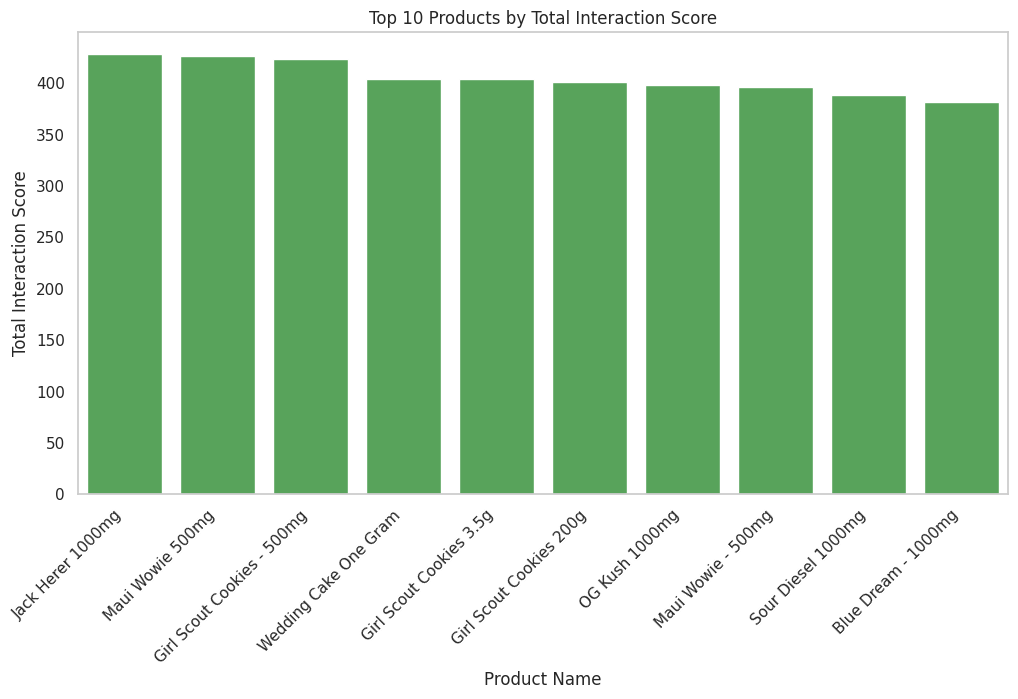

In [98]:
# aggregate total interaction per product
product_interx = merged_df.groupby('product_id')['interaction_score'].sum().reset_index()
product_interx = product_interx.merge(products_df[['product_id', 'name']], on = 'product_id')
plotdata = product_interx.sort_values('interaction_score', ascending = False)

# plot

plt.figure(figsize = (12, 6))
ax = sns.barplot(x = 'name', y = 'interaction_score', color = '#4CAF50',
            data = plotdata.head(10))

# remove grid lines
ax.grid(False)

plt.xticks(rotation = 45, ha = 'right')
plt.title('Top 10 Products by Total Interaction Score')
plt.ylabel('Total Interaction Score')
plt.xlabel('Product Name')
plt.show()


In [86]:
product_interx.sort_values('interaction_score', ascending = False).head(10)

,product_id,interaction_score,name
64,p065,428.0,Jack Herer 1000mg
25,p026,426.0,Maui Wowie 500mg
95,p096,423.0,Girl Scout Cookies - 500mg
92,p093,404.0,Wedding Cake One Gram
66,p067,404.0,Girl Scout Cookies 3.5g
96,p097,401.0,Girl Scout Cookies 200g
50,p051,398.0,OG Kush 1000mg
49,p050,396.0,Maui Wowie - 500mg
47,p048,388.0,Sour Diesel 1000mg
84,p085,382.0,Blue Dream - 1000mg


In [87]:
product_similarity_df = pd.DataFrame(product_similarity, index = product_ids, columns = product_ids)
product_similarity_df.head()

,p001,p002,p003,p004,p005,p006,p007,p008,p009,p010,...,p091,p092,p093,p094,p095,p096,p097,p098,p099,p100
p001,1.000000,0.114972,0.173549,0.229977,0.200714,0.182580,0.141776,0.322792,0.183152,0.165544,...,0.240692,0.245294,0.213307,0.193066,0.130939,0.236451,0.265046,0.178615,0.380434,0.199554
p002,0.114972,1.000000,0.298860,0.321633,0.265738,0.205465,0.236319,0.094625,0.137480,0.060333,...,0.131102,0.128840,0.203861,0.152643,0.176429,0.219212,0.201402,0.189395,0.173360,0.142153
p003,0.173549,0.298860,1.000000,0.264425,0.128356,0.244435,0.157509,0.195586,0.296490,0.174464,...,0.213768,0.247151,0.218839,0.263878,0.092486,0.330485,0.201520,0.236805,0.223057,0.141498
p004,0.229977,0.321633,0.264425,1.000000,0.300676,0.136124,0.218206,0.128769,0.159441,-0.043731,...,0.222144,0.267259,0.272976,0.111299,0.238731,0.332253,0.277989,0.216993,0.234664,0.260879
p005,0.200714,0.265738,0.128356,0.300676,1.000000,0.203749,0.157672,0.198607,0.172260,0.117258,...,0.248996,0.329478,0.225336,0.388333,0.118294,0.276332,0.189296,0.174167,0.059502,0.266978


### 7d. Heatmap of Top 10 Interacted Product Similarities

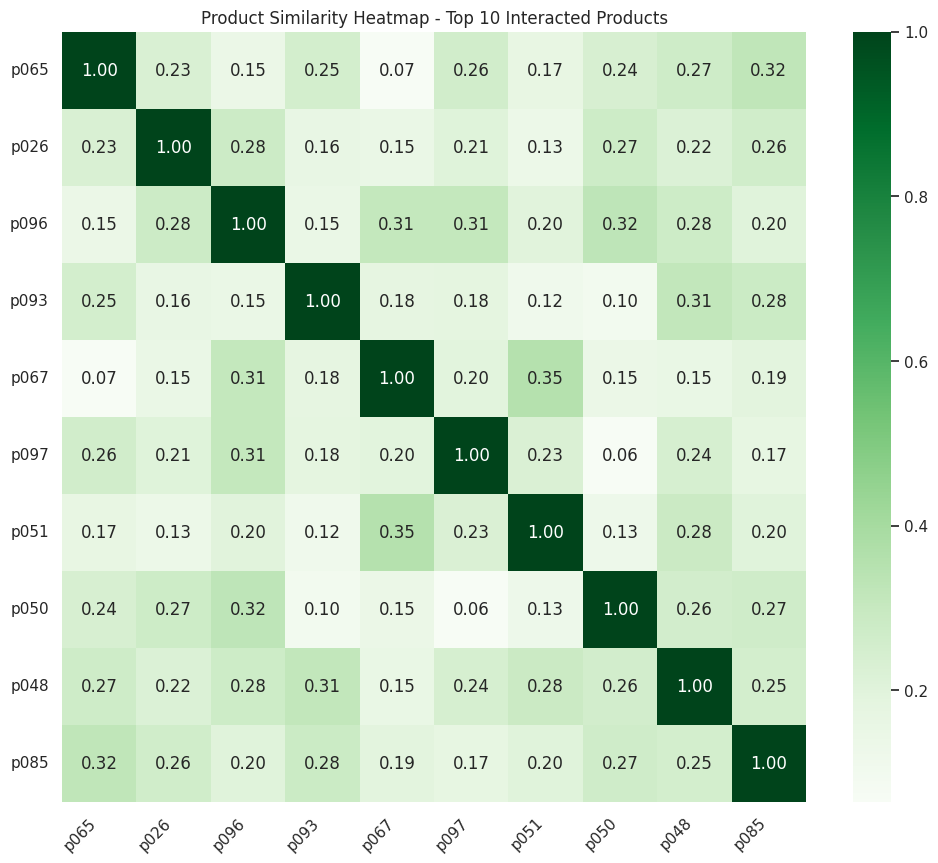

In [88]:
# select top 10 interacted products
top_10products_df = product_interx.sort_values('interaction_score', ascending = False).head(10)
top_10product_ids = top_10products_df['product_id'].tolist()
top_10product_names = top_10products_df['name'].tolist()

# subset the similarity matrix for these top 10 interacted products
top_similarity_matrix = product_similarity_df.loc[top_10product_ids, top_10product_ids]

# plot heatmap
plt.figure(figsize = (12, 10))
sns.heatmap(top_similarity_matrix,
            xticklabels = top_10product_ids,
            yticklabels = top_10product_ids,
            cmap = 'Greens',
            annot = True, fmt = ".2f")  # annot = True shows similarity values
plt.title('Product Similarity Heatmap - Top 10 Interacted Products')
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 0)
plt.show()

Let's look at the two closes ones with a similarity score of 0.35, which is far from perfectly similar. Product id #p067 and #p051.

In [89]:
products_df[product_interx['product_id'] == 'p067']

,product_id,name,category,strain_type,strain,vendor,THC_pct,CBD_pct,potency_mg,price_usd,availability,description,tags,date_added,text_feature
66,p067,Girl Scout Cookies 3.5g,Flower,Sativa,Girl Scout Cookies,Sunset Wellness,24.0,1.3,NaN,61.49,410,Girl Scout Cookies Sativa flower with energeti...,"['energetic', 'focused', 'uplifting', 'cerebral']",2025-04-24,Girl Scout Cookies 3.5g Sativa Flower Girl Sco...


In [93]:
products_df[product_interx['product_id'] == 'p051']

,product_id,name,category,strain_type,strain,vendor,THC_pct,CBD_pct,potency_mg,price_usd,availability,description,tags,date_added,text_feature
50,p051,OG Kush 1000mg,Concentrate,Sativa,OG Kush,Elevate Extracts,78.2,1.6,750.0,50.31,446,"OG Kush Sativa concentrate with energetic, cre...","['energetic', 'creative', 'focused', 'cerebral']",2025-03-14,OG Kush 1000mg Sativa Concentrate OG Kush Sati...


### 7e. Top 5 Recommended Products Across All Users

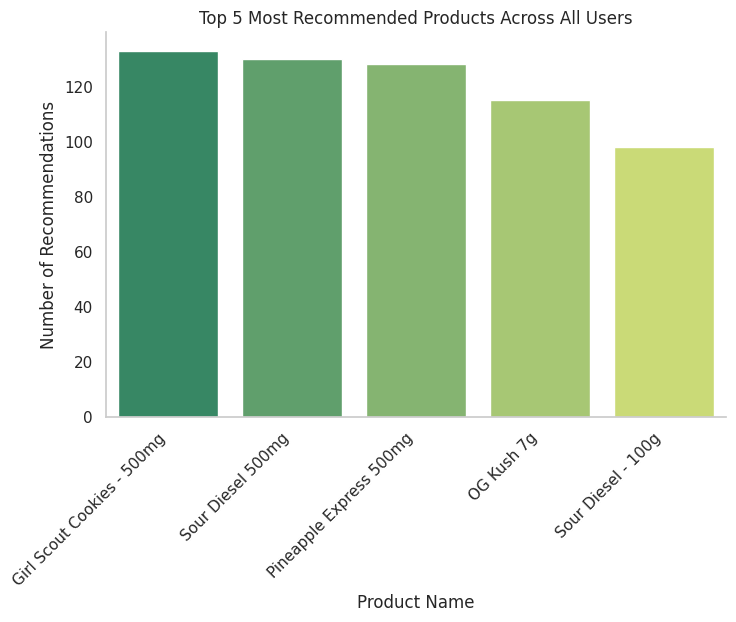

In [96]:
from collections import Counter

# flatten all top-5 recommendations across all users
all_recommended = [pid for recs in recommendations.values() for pid in recs]

# count frequency of each product
top_counts = Counter(all_recommended)

# convert to dataframe for plotting
top_df = pd.DataFrame(top_counts.items(), columns = ['product_id','recommend_count'])
top_df = top_df.merge(products_df[['product_id','name']], on = 'product_id')
top_df = top_df.sort_values('recommend_count', ascending = False).head(5)

# plot
plt.figure(figsize = (8,5))
ax = sns.barplot(x = 'name', y ='recommend_count', hue = 'name', data = top_df,
            palette = 'summer')

# remove grid lines
ax.grid(False)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.title('Top 5 Most Recommended Products Across All Users')
plt.ylabel('Number of Recommendations')
plt.xlabel('Product Name')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

### 7f. Category Distribution of Recommended Products

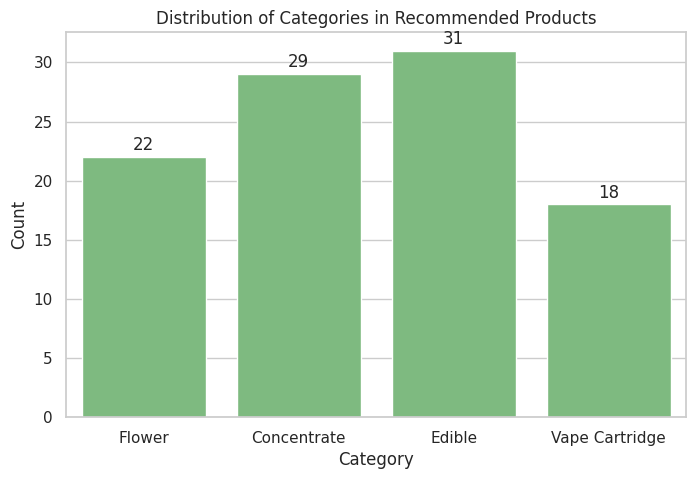

In [92]:
recommended_products_flat = [pid for recs in recommendations.values() for pid in recs]
recommended_df = products_df[products_df['product_id'].isin(recommended_products_flat)]

plt.figure(figsize = (8,5))
ax = sns.countplot(x = 'category', data = recommended_df, color = '#74c476')
plt.title('Distribution of Categories in Recommended Products')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width()/2,
            height + 1,
            int(height),
            ha = 'center',
            va = 'center')

plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# 8.0 Conclusion

In this project, we analyzed user behavior and product attributes on an e-commerce cannabis platform to model purchase propensity and deliver personalized recommendations.

### Key takeaways:

---

**Purchase Propensity Modeling:**

---

Although our models (Logistic Regression, XGBoost) did not outperform random chance in terms of overall accuracy, the process highlighted the challenges of predicting purchases with limited behavioral signals and class imbalance. Focusing on recall remains important for identifying potential buyers if more informative features become available.

Additionally, the simulated dataset is inherently stochastic and unconditioned on meaningful features like price sensitivity, brand loyalty, or demographics which would have been in the case in the real world. Funnel steps (click, save, cart, buy) are determined using `random.random()` with global probabilities applied uniformly across users and products. As a result, purchase outcomes are effectively weighted coin flips, and no true correlation exists between features and labels. Consequently, the best a classification model can do is hover around the base probabilities (~50% for purchase propensity). To make the model learn meaningful patterns, the simulation would need to bias probabilities based on features such as product price, category, stock availability, brand loyalty, seasonality, and or discounts.

---

**Hybrid Recommendation System:**

---

Despite the limitations of the simulated data, we implemented a hybrid recommendation approach combining text-based scoring (cosine similarity of product descriptions and user's preferences) and graph-based scoring (dot product of embeddings capturing user-product interactions). By weighting these components, we provided a framework for suggesting products that reflect both product similarity and user behavior patterns.

---

**Business Impact:**

---

While the predictive models do not outperform chance in this setup, the hybrid recommendation approach can still guide users toward relevant products and increase engagement. This approach also provides a foundation for further testing, such as A/B experiments to measure recommendation effectiveness. The exercise also highlights how simulation design affects model learnability, emphasizing the importance of feature-conditioned probabilities for future work.

Future enhancements could include refining the embedding methods, or incorporating session-level behavior, or more feature rich information to further improve modeling performance and recommendation relevance.

Overall, this project demonstrates how predictive modeling and hybrid recommendation techniques can help online businesses better understand user behavior, personalize the shopping experience, and grow e-commerce revenue in the cannabis market.